In [27]:
import numpy as np
import pandas as pd 
import sqlite3  
from matplotlib import pyplot as plt
from matplotlib import style 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
from sqlalchemy import create_engine
import seaborn as sns

In [28]:
import xml.etree.ElementTree as ET
from xml import etree
from lxml import objectify


In [29]:
#loading data form the sqlite database 
with sqlite3.connect('database.sqlite') as con: 
    countries = pd.read_sql_query("SELECT * from Country", con)
    league = pd.read_sql_query("SELECT * from league ", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    Teams = pd.read_sql_query ("SELECT * from Team",con)

In [30]:
# selecting the relevant information 
selected_countries = ['England']
countries = countries[countries.name.isin(selected_countries)]
league = countries.merge(league,on='id', suffixes =('','_y'))

# retain only data from 17/08/2002
#['match_apid_id' 'home_team_goals' 'away_team_goals'] not in index"
#matches=matches[matches.date>='2002-08-17']
matches = matches[matches.league_id.isin(league.id)]
matches = matches[['id','country_id','league_id','season','match_api_id','home_team_api_id',
                   'away_team_api_id','home_team_goal','away_team_goal','cross','possession','date']]
matches.dropna(inplace=True)
#matches

In [31]:
def extract_possession(data,minute,team):
    #print(data)
    if data :
        root = ET.fromstring(data)
        tree = ET.ElementTree(root)
        root = tree.getroot()
        for c in root.getchildren():
            elapsed = c.find("elapsed")
            try :
                if int(elapsed.text) == minute :
                    if team == "away" :
                        away = c.find("awaypos")
                        if away is not None :
                            return int(away.text)
                    else :
                        home = c.find("homepos")
                        if home is not None :
                            return int(home.text)
            except:
                print(data)
    return None

In [32]:
#root = ET.fromstring("<possession><value><comment>56</comment><event_incident_typefk>352</event_incident_typefk><elapsed>25</elapsed><subtype>possession</subtype><sortorder>1</sortorder><awaypos>44</awaypos><homepos>56</homepos><n>68</n><type>special</type><id>379029</id></value><value><comment>54</comment><elapsed_plus>1</elapsed_plus><event_incident_typefk>352</event_incident_typefk><elapsed>45</elapsed><subtype>possession</subtype><sortorder>4</sortorder><awaypos>46</awaypos><homepos>54</homepos><n>117</n><type>special</type><id>379251</id></value><value><comment>54</comment><event_incident_typefk>352</event_incident_typefk><elapsed>70</elapsed><subtype>possession</subtype><sortorder>0</sortorder><awaypos>46</awaypos><homepos>54</homepos><n>190</n><type>special</type><id>379443</id></value><value><comment>55</comment><elapsed_plus>5</elapsed_plus><event_incident_typefk>352</event_incident_typefk><elapsed>90</elapsed><subtype>possession</subtype><sortorder>1</sortorder><awaypos>45</awaypos><homepos>55</homepos><n>252</n><type>special</type><id>379575</id></value></possession>")

In [33]:
#tree = ET.ElementTree(root)
#root = tree.getroot()
#children = root.getchildren()
#a=children[0]
#b=a.find("elapsed")
#b.value

In [34]:
matches['possesion_h_45']=matches.apply( lambda x: extract_possession(x.possession,45,"home"), axis=1) 

In [35]:
matches['possesion_a_45']=matches.apply( lambda x: extract_possession(x.possession,45,"away"), axis=1) 

In [36]:
matches['possesion_h_90']=matches.apply( lambda x: extract_possession(x.possession,90,"home"), axis=1) 

In [37]:
matches['possesion_a_90']=matches.apply( lambda x: extract_possession(x.possession,90,"away"), axis=1) 

In [38]:
Possession_Table = pd.DataFrame (data=matches, columns=['id', 'country_id', 'league_id', 'season', 'match_api_id','date',
       'home_team_api_id', 'away_team_api_id','home_team_goal', 'away_team_goal',
       'possesion_a_45', 'possesion_h_45', 'possesion_h_90', 'possesion_a_90'])

In [39]:
#Possession_Table.head()

In [42]:
Possession_Table=Possession_Table.merge(Teams,left_on='home_team_api_id',right_on='team_api_id',suffixes=('','_h'))
Possession_Table=Possession_Table.merge(Teams,left_on='away_team_api_id',right_on='team_api_id',suffixes=('','_a'))

In [43]:
Possession_Table = Possession_Table[['season','date',
                                    'team_long_name_h','team_long_name_a','home_team_goal',
                                    'away_team_goal','possesion_h_45','possesion_a_45','possesion_h_90',
                                    'possesion_a_90']]

Possession_Table.columns = ['Season', 'Date','HomeTeam','AwayTeam','','FTHG','FTAG',
                            'possesion_h_45','possesion_a_45', 'possesion_h_90','possesion_a_90']

Possession_Table = Possession_Table[['Season', 'Date','HomeTeam','AwayTeam','FTHG','FTAG',
                            'possesion_h_45','possesion_a_45', 'possesion_h_90','possesion_a_90']]

In [44]:
Possession_Table['HomeResult'] = np.where(Possession_Table['FTHG'] > Possession_Table['FTAG'],'W',
                                (np.where(Possession_Table['FTHG'] == Possession_Table['FTAG'],'D','L' )))

Possession_Table['AwayResult'] = np.where(Possession_Table['FTAG'] > Possession_Table['FTHG'],'W',
                                (np.where(Possession_Table['FTAG'] == Possession_Table['FTHG'],'D','L' )))
Possession_Table.columns

Index(['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'possesion_h_45', 'possesion_a_45', 'possesion_h_90', 'possesion_a_90',
       'HomeResult', 'AwayResult'],
      dtype='object')

In [45]:
Home_Wins =Possession_Table
Home_Wins = Home_Wins[['Season', 'Date', 'HomeTeam','possesion_h_45', 'possesion_h_90', 
                      'HomeResult']]
Home_Wins.columns = ['Season', 'Date', 'Team', 'possesion_h_45','possesion_h_90','Result']
Home_Wins.to_csv("Home_Pos.csv")

In [46]:
Away_Wins =Possession_Table

Away_Wins = Away_Wins[['Season', 'Date', 'AwayTeam', 'possesion_a_45','possesion_a_90', 'AwayResult']]

Away_Wins.columns = ['Season', 'Date', 'Team','possesion_a_45','possesion_a_90','Result']
Away_Wins.to_csv("Away_Pos.csv")

In [59]:
Winner = pd.concat([Home_Wins,Away_Wins],axis=0)
Wins =Winner[Winner['Result']== 'W']
Wins = pd.DataFrame (data=Wins, columns=['Season','Team','Result'])
Wins.columns = ['Season', 'Team','Wins']
WinStats = Wins.groupby(['Season','Team']).count()
WinStats= WinStats.reset_index()
WinStats.head()
#Wins.head()
#inner.to_csv("Possession.csv")

Season              Team  Wins
0  2008/2009           Arsenal    20
1  2008/2009       Aston Villa    17
2  2008/2009  Blackburn Rovers    10
3  2008/2009  Bolton Wanderers    11
4  2008/2009           Chelsea    25

In [60]:
AvgStats=Winner.groupby(['Team','Season']).mean()
AvgStats=AvgStats.reset_index()
#AvgStats.tail()

In [61]:
Pos_LeagueStats = pd.merge(AvgStats, WinStats, on=['Season','Team'])
Pos_LeagueStats.tail()

Team     Season  possesion_a_45  possesion_a_90  \
155           Wigan Athletic  2011/2012       51.333333       49.000000   
156           Wigan Athletic  2012/2013       48.000000       49.153846   
157  Wolverhampton Wanderers  2009/2010       43.277778       42.631579   
158  Wolverhampton Wanderers  2010/2011       45.000000       45.416667   
159  Wolverhampton Wanderers  2011/2012       46.000000       44.000000   

     possesion_h_45  possesion_h_90  Wins  
155       49.000000       52.384615    11  
156       52.727273       53.583333     9  
157       50.315789       49.789474     9  
158       49.888889       52.800000    11  
159       47.615385       44.333333     5

# Data Visualisation

Correlation Coefficient 
[[ 1.          0.66217828]
 [ 0.66217828  1.        ]]


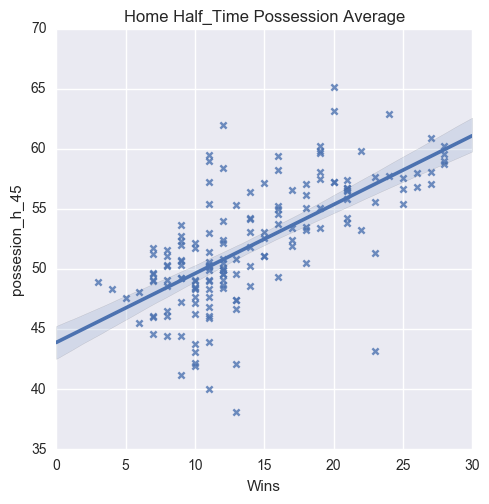

In [72]:
sns.lmplot(y='possesion_h_45',x='Wins',data=Pos_LeagueStats, markers=["x"]);
sns.plt.title('Home Half_Time Possession Average');
print (('Correlation Coefficient '))
print (np.corrcoef (Pos_LeagueStats.possesion_h_45, Pos_LeagueStats.Wins))


Correlation Coefficient 
[[ 1.          0.67027903]
 [ 0.67027903  1.        ]]


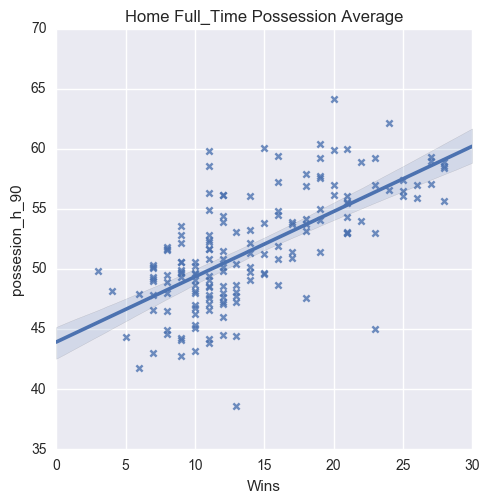

In [73]:
sns.lmplot(y='possesion_h_90',x='Wins',data=Pos_LeagueStats, markers=["x"]);
sns.plt.title('Home Full_Time Possession Average');
print (('Correlation Coefficient '))
print (np.corrcoef (Pos_LeagueStats.possesion_h_90, Pos_LeagueStats.Wins))


Correlation Coefficient 
[[ 1.          0.61718503]
 [ 0.61718503  1.        ]]


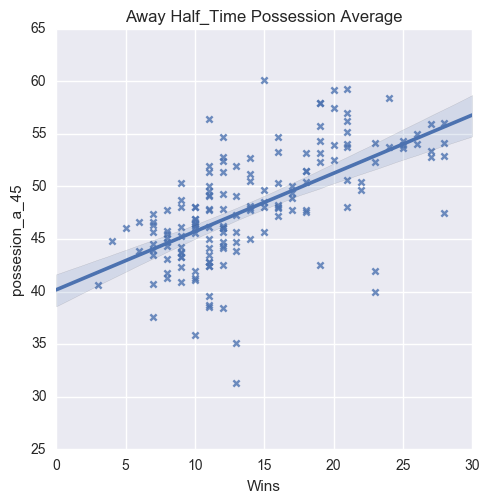

In [74]:
sns.lmplot(y='possesion_a_45',x='Wins',data=Pos_LeagueStats, markers=["x"]);
sns.plt.title('Away Half_Time Possession Average');
print (('Correlation Coefficient '))
print (np.corrcoef (Pos_LeagueStats.possesion_a_45, Pos_LeagueStats.Wins))


Correlation Coefficient 
[[ 1.          0.67129772]
 [ 0.67129772  1.        ]]


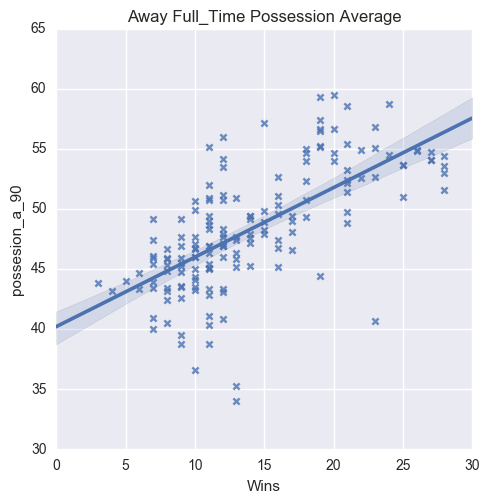

In [75]:
sns.lmplot(y='possesion_a_90',x='Wins',data=Pos_LeagueStats, markers=["x"]);
sns.plt.title('Away Full_Time Possession Average');
print (('Correlation Coefficient '))
print (np.corrcoef (Pos_LeagueStats.possesion_a_90, Pos_LeagueStats.Wins))
